# CIFAR-10
Coach: [Dylan](http://liqing-ustc.github.io/) / [Github](https://github.com/TFTxiaozu/TFT-ML-Week-3)

## Introduction

CIFAR-10 classification is a common benchmark problem in machine learning. The problem is to classify RGB 32x32 pixel images across 10 categories:

airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

Refer to [CIFAR-10 webpage](https://www.cs.toronto.edu/~kriz/cifar.html) for more details.

# 1. Load data

The CIFAR-10 data-set is about 163 MB and will be downloaded automatically if it is not located in the given path. It might take a few minutes to download. Just wait.

In [1]:
import cifar10
cifar10.maybe_download_and_extract()

- Download progress: 100.0%
Download finished. Extracting files.
Done.


Load the class-names.

In [2]:
class_names = cifar10.load_class_names()
print(class_names)

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Load the training-set. This returns the images, the class-numbers as integers, and the class-numbers as One-Hot arrays called labels.

In [3]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


In [4]:
print(images_train.shape)
print(cls_train.shape)
print(labels_train.shape)

(50000, 32, 32, 3)
(50000,)
(50000, 10)


Load the test-set.

In [5]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [6]:
print(images_test.shape)
print(cls_test.shape)
print(labels_test.shape)

(10000, 32, 32, 3)
(10000,)
(10000, 10)


The CIFAR-10 data-set has now been loaded and consists of 60,000 images and associated labels (i.e. classifications of the images). The data-set is split into 2 mutually exclusive sub-sets, the training-set and the test-set.

In [7]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Size of:
- Training-set:		50000
- Test-set:		10000


Data Dimensions

In [8]:
from cifar10 import img_size, num_channels, num_classes
print(img_size)
print(num_channels) # RGB
print(num_classes)

32
3
10


Plot a few images to see.

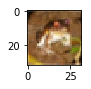

frog


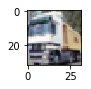

truck


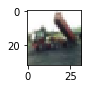

truck


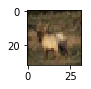

deer


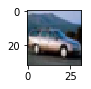

automobile


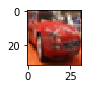

automobile


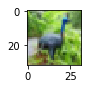

bird


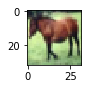

horse


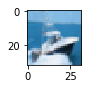

ship


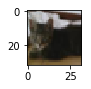

cat


In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(10):
    img = images_train[i]
    label = labels_train[i]
    
    plt.figure(figsize=(1,1))
    plt.imshow(img)
    plt.show()
    cls = np.argmax(label)
    cls_name = class_names[cls]
    print(cls_name)

# 2. Train a two-layer neural network on CIFAR-10

### Build the compuation graph.

In [10]:
import tensorflow as tf

# 1. Create the model (build the compuation graph)
## Hyperparameters
batch_size = 64
n_input = 32*32*3 # image is 32x32x3
n_hidden = 256
n_classes = 10
learning_rate = 0.01


## Model input
x = tf.placeholder(tf.float32, [None, n_input])

## Hidden layer
W1 = tf.Variable(tf.random_normal([n_input, n_hidden], stddev=0.1))
b1 = tf.Variable(tf.zeros([n_hidden]))
h1 = tf.matmul(x, W1) + b1
h1 = tf.nn.relu(h1)

## Output layer
W_out = tf.Variable(tf.random_normal([n_hidden, n_classes], stddev=0.1))
b_out = tf.Variable(tf.zeros([n_classes]))
y_pred = tf.matmul(h1, W_out) + b_out

#W1 = tf.Variable(tf.random_normal([n_input, n_classes], stddev=0.1))
#b1 = tf.Variable(tf.zeros([n_classes]))
#y_pred = tf.matmul(x, W1) + b1


## Define loss and optimizer
y_gt = tf.placeholder(tf.float32, [None, n_classes])
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=y_pred, labels=y_gt, name='loss'))

## Train (update model parameters)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
optimizer = tf.train.AdamOptimizer()
train_step = optimizer.minimize(loss)

## Compute Accuracy
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_gt, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))



/Users/qingli/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Helper-function to get a random training-batch

There are 50,000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer.

If your computer crashes or becomes very slow because you run out of RAM, then you may lower the batch size, but you may then need to perform more optimization iterations.

In [11]:
def random_batch(images_train, labels_train, batch_size):
    # Number of images in the training-set.
    num_images = len(images_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = images_train[idx]
    y_batch = labels_train[idx]

    return x_batch, y_batch

### Train

In [12]:
## Initialize
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

max_iter = 500

images_train = images_train.reshape([50000, -1])
images_test = images_test.reshape([10000, -1])

for iter in range(max_iter):
    batch_x, batch_y = random_batch(images_train, labels_train, batch_size)
    sess.run(train_step, feed_dict = {x: batch_x, y_gt: batch_y})
    if iter % 100 == 0:
        train_loss = sess.run(loss, feed_dict = {x: batch_x, y_gt: batch_y})
        train_accuracy = sess.run(accuracy, feed_dict = {x: batch_x, y_gt: batch_y})
        
        test_x = images_test
        test_y = labels_test
        test_accuracy = sess.run(accuracy, {x: test_x, y_gt: test_y})
        
        print("iter step %d, loss %f, training accuracy %f, test accuracy %f" %
              (iter, train_loss, train_accuracy, test_accuracy))

iter step 0, loss 5.385572, training accuracy 0.156250, test accuracy 0.089200
iter step 100, loss 2.117245, training accuracy 0.359375, test accuracy 0.261800
iter step 200, loss 1.878751, training accuracy 0.312500, test accuracy 0.311100
iter step 300, loss 1.726026, training accuracy 0.421875, test accuracy 0.325300
iter step 400, loss 1.661317, training accuracy 0.343750, test accuracy 0.347000


### Use some examples to test your model 

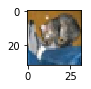

Ground Truth: cat
Model prediction: cat


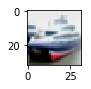

Ground Truth: ship
Model prediction: truck


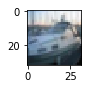

Ground Truth: ship
Model prediction: ship


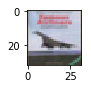

Ground Truth: airplane
Model prediction: airplane


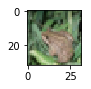

Ground Truth: frog
Model prediction: deer


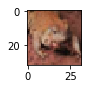

Ground Truth: frog
Model prediction: frog


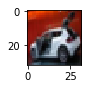

Ground Truth: automobile
Model prediction: cat


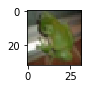

Ground Truth: frog
Model prediction: frog


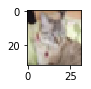

Ground Truth: cat
Model prediction: bird


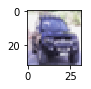

Ground Truth: automobile
Model prediction: ship


In [13]:
images_train = images_train.reshape([50000, 32, 32, 3])
images_test = images_test.reshape([10000, 32, 32, 3])
for i in range(10):
    img = images_test[i]
    label = labels_test[i]
    
    plt.figure(figsize=(1,1))
    plt.imshow(img)
    plt.show()
    cls = np.argmax(label)
    cls_name = class_names[cls]
    print("Ground Truth: %s" % cls_name)
    
    pred_label = sess.run(y_pred, feed_dict = {x: img.reshape([1, -1])})
    pred_cls = np.argmax(pred_label)
    pred_cls_name = class_names[pred_cls]
    print("Model prediction: %s" % pred_cls_name)